In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/phantom3'


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# List all files in the directory
all_files = os.listdir(data_dir)

# Separate image and mask files based on your naming convention
image_files = [f for f in all_files if 'Fluoroscopy_Image' in f]
mask_files = [f for f in all_files if 'Annotation' in f]

# Sort files to ensure they are paired correctly
image_files.sort()
mask_files.sort()

# Load and preprocess the images and masks
images = []
masks = []

Number of images: 33
Number of masks: 33


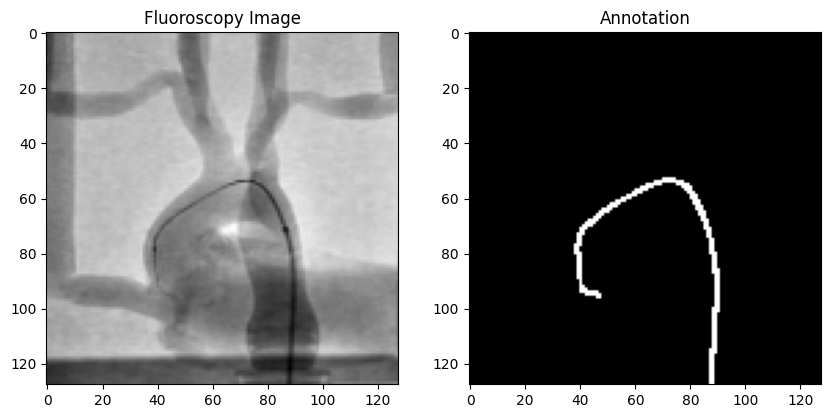

In [ ]:
for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(data_dir, image_file)
    mask_path = os.path.join(data_dir, mask_file)

    # Load image and mask
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if image and mask are loaded correctly
    if image is not None and mask is not None:
        # Normalize image
        image = image / 255.0

        # Resizing
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        # Ensure mask is binary
        mask = (mask > 0).astype(np.float32)

        # Expanding dimensions to fit the model input shape
        image = np.expand_dims(image, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        # Append to lists
        images.append(image)
        masks.append(mask)
    else:
        print(f"Error loading {image_file} or {mask_file}")

# Convert lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit the data generators
image_datagen.fit(X_train, augment=True)
mask_datagen.fit(y_train, augment=True)

# Create the data generators
seed = 1
batch_size = 32
train_image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
train_mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

# Combine generators into one which yields image and masks
train_generator = (pair for pair in zip(train_image_generator, train_mask_generator))
#def train_generator():
    #for image_batch, mask_batch in zip(train_image_generator, train_mask_generator):
        #yield image_batch, mask_batch  # Yield batches as separate arguments

# Validation generator without augmentation
val_image_datagen = ImageDataGenerator()
val_mask_datagen = ImageDataGenerator()

val_image_datagen.fit(X_val, augment=False)
val_mask_datagen.fit(y_val, augment=False)

val_image_generator = val_image_datagen.flow(X_val, batch_size=batch_size, seed=seed)
val_mask_generator = val_mask_datagen.flow(y_val, batch_size=batch_size, seed=seed)

val_generator = (pair for pair in zip(val_image_generator, val_mask_generator))




# Verify the loaded data
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

# Plot some samples
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Fluoroscopy Image')
plt.imshow(X_train[0].squeeze(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Annotation')
plt.imshow(y_train[0].squeeze(), cmap='gray')
plt.show()

# Train Unet Model







In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.models import Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from scipy.ndimage import distance_transform_edt as distance

@tf.keras.utils.register_keras_serializable()
def weighted_binary_crossentropy(weights):
    @tf.keras.utils.register_keras_serializable()
    def loss(y_true, y_pred):
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        loss = K.binary_crossentropy(y_true, y_pred)
        loss = loss * (weights[1] * y_true + weights[0] * (1 - y_true))
        return K.mean(loss)
    return loss

weights = [0.1, 0.9]

@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def rdice_coefficient(y_true, y_pred, smooth=1):
    return dice_coefficient(y_true, y_pred, smooth)

# clDice coefficient

def cl_dice_coefficient(y_true, y_pred, smooth=1):

    def cl_score(mask1, mask2):
        S1 = K.round(K.clip(mask1, 0, 1))
        S2 = K.round(K.clip(mask2, 0, 1))

        def distance_transform(mask):
            mask_np = mask.numpy()
            return distance(mask_np).astype(np.float32)

        S1_dt = tf.numpy_function(distance_transform, [S1], tf.float32)
        S2_dt = tf.numpy_function(distance_transform, [S2], tf.float32)

        cl_S = (S1 * S2_dt) + (S2 * S1_dt)
        cl_S = K.sum(cl_S, axis=(1, 2, 3))

        return 2 * cl_S / (K.sum(S1, axis=(1, 2, 3)) + K.sum(S2, axis=(1, 2, 3)) + K.epsilon())

    def dice_coefficient(y_true, y_pred, smooth=1):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    dice = dice_coefficient(y_true, y_pred, smooth)
    cl_dice = cl_score(y_true, y_pred)
    return (dice + cl_dice) / 2

In [ ]:
# Define the directory in Google Drive
drive_directory = '/content/drive/MyDrive/UNET_MODEL'

# Define file paths
model_save_path = os.path.join(drive_directory, 'unet_final_model.keras')
history_save_path = os.path.join(drive_directory, 'training_history.pkl')
predictions_save_path = os.path.join(drive_directory, 'model_predictions.npy')

# **NOT USED**

In [ ]:
# NOT USED


weights = [0.1, 0.9]
def combined_loss(weights):
    def weighted_binary_crossentropy(y_true, y_pred):
        b_ce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * weights[1] + (1. - y_true) * weights[0]
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)

    def dice_loss(y_true, y_pred):
        smooth = 1.0
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def loss(y_true, y_pred):
        return weighted_binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

    return loss

# U NET MODEL

In [ ]:
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoding path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.3)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoding path
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss= weighted_binary_crossentropy(weights), metrics=['accuracy',iou_metric, dice_coefficient,rdice_coefficient,tf.keras.metrics.AUC()])

    return model

model = unet_model(input_size=(128, 128, 1))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
model = unet_model()

# Calculate steps_per_epoch and validation_steps
batch_size = 2
steps_per_epoch = max(1, len(X_train) // batch_size)
validation_steps = max(1, len(X_val) // batch_size)

# Define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001) # changed from 0.0001 to 0.00001 , I think their will be some improvements
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping, reduce_lr,model_checkpoint])
model.save(model_save_path)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 473ms/step - accuracy: 0.9566 - auc_34: 0.5614 - dice_coefficient: 0.0315 - iou_metric: 0.0043 - loss: 0.0919 - rdice_coefficient: 0.0315 - val_accuracy: 0.9760 - val_auc_34: 0.7776 - val_dice_coefficient: 0.0599 - val_iou_metric: 0.0000e+00 - val_loss: 0.0561 - val_rdice_coefficient: 0.0599 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.9710 - auc_34: 0.7755 - dice_coefficient: 0.0547 - iou_metric: 0.0000e+00 - loss: 0.0377 - rdice_coefficient: 0.0547 - val_accuracy: 0.9760 - val_auc_34: 0.8358 - val_dice_coefficient: 0.0765 - val_iou_metric: 0.0000e+00 - val_loss: 0.0466 - val_rdice_coefficient: 0.0765 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - accuracy: 0.9701 - auc_34: 0.8344 - dice_coefficient: 0.0754 - iou_metric: 0.0107 - loss: 0.0339 - rdice_coefficient: 0.0754 - val_accuracy: 0.9764 - val_auc_34: 0.8530 - val_dice_coefficient: 0.1222 - val_iou_metric: 0.0171 

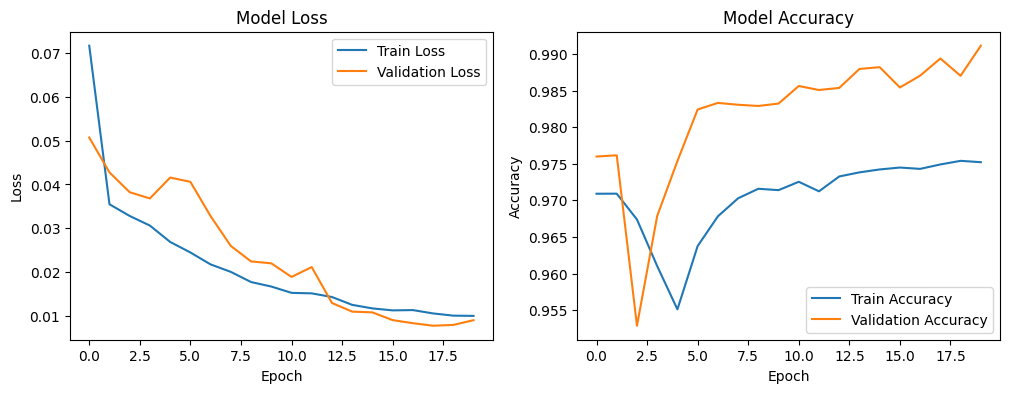

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()

In [ ]:

# Evaluate the model on the training data
test_metrics = model.evaluate(X_train, y_train, batch_size=batch_size)

# Unpack the returned metrics
(test_loss, test_accuracy, test_iou_metric, test_dice_coefficient,
 test_rdice_coefficient, test_cl_dice_coefficient, test_auc) = test_metrics

# Print the metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test IoU Metric: {test_iou_metric:.4f}')
print(f'Test Dice Coefficient: {test_dice_coefficient:.4f}')
print(f'Test RDice Coefficient: {test_rdice_coefficient:.4f}')
print(f'Test clDice Coefficient: {test_cl_dice_coefficient:.4f}')
print(f'Test AUC: {test_auc:.4f}')




13/13 [==============================] - 2s 18ms/step - loss: 0.0060 - accuracy: 0.9907 - iou_metric: 0.6504 - dice_coefficient: 0.6204 - rdice_coefficient: 0.6204 - cl_dice_coefficient: 1.1386 - auc_1: 0.9978
Test Loss: 0.0060
Test Accuracy: 0.9907
Test IoU Metric: 0.6504
Test Dice Coefficient: 0.6204
Test RDice Coefficient: 0.6204
Test clDice Coefficient: 1.1386
Test AUC: 0.9978


1/1 [==============================] - 2s 2s/step


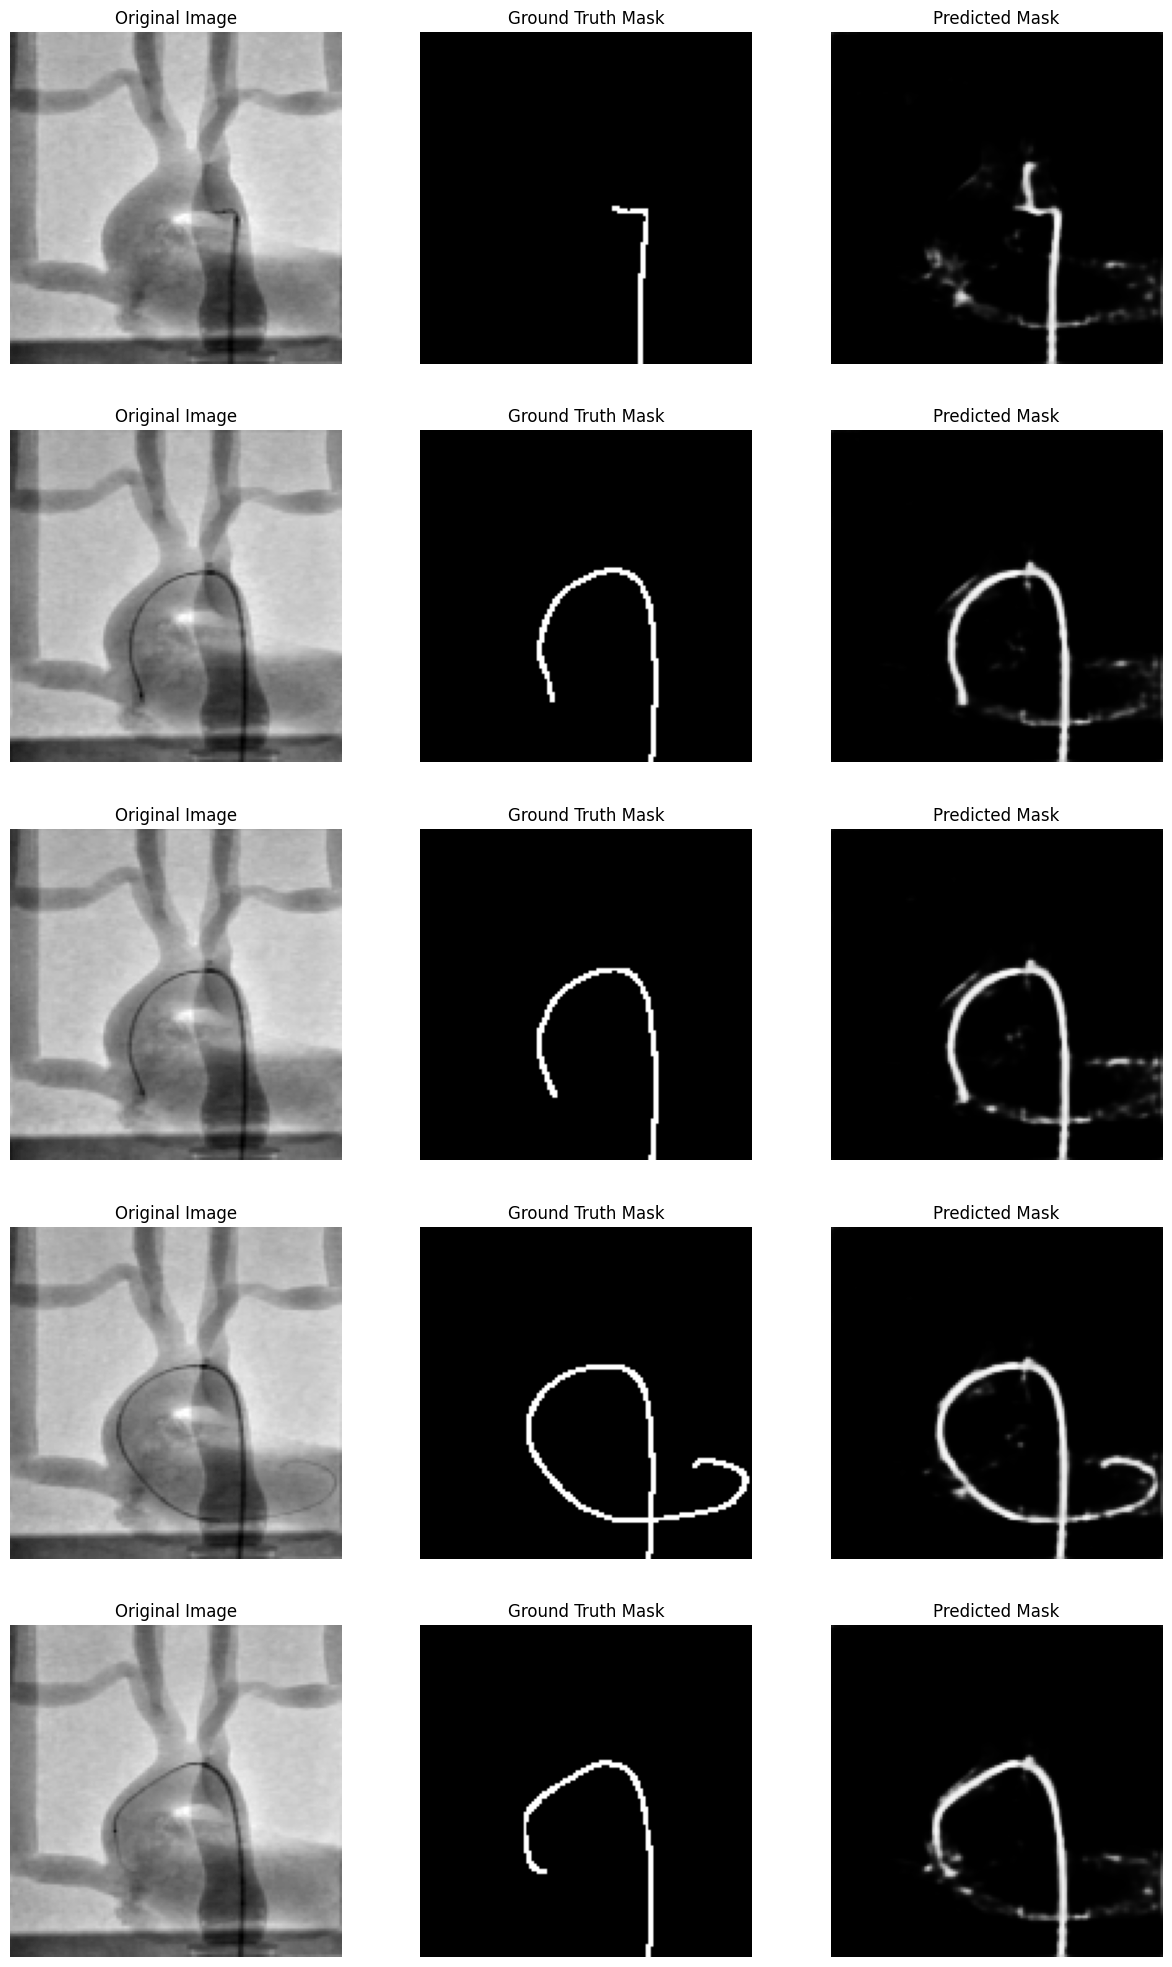

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(model, images, masks, num_samples=5):
    # Shuffle indices to select random samples
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    selected_indices = indices[:num_samples]

    selected_images = images[selected_indices]
    selected_masks = masks[selected_indices]

    predictions = model.predict(selected_images)

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(np.squeeze(selected_images[i]), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(np.squeeze(selected_masks[i]), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(np.squeeze(predictions[i]), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# Example usage
# Assuming `model`, `images`, and `masks` are already defined
plot_sample_images(model, images, masks)



# **Evaluate the Model on Unseen T1T4 Data**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.segmentation import active_contour
from skimage.filters import gaussian

In [ ]:
def post_process(prediction, threshold=0.55):
    try:
        # Apply a slightly higher threshold to get binary mask
        binary_mask = (prediction > threshold).astype(np.uint8)
        print("Binary mask shape:", binary_mask.shape)

        # Apply morphological opening to remove noise
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_open, iterations=1)
        print("Opened mask shape:", opened_mask.shape)

        # Apply morphological closing to fill gaps
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        closed_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel_close, iterations=1)
        print("Closed mask shape:", closed_mask.shape)

        # Remove small noise using connected component analysis
        num_labels, labels_im = cv2.connectedComponents(closed_mask)
        print("Number of labels:", num_labels)

        if num_labels > 1:
            # Create a mask with only the largest connected component
            sizes = cv2.connectedComponentsWithStats(closed_mask)[2][:, -1]
            largest_label = 1 + np.argmax(sizes[1:])  # +1 because 0 is the background
            largest_component_mask = (labels_im == largest_label).astype(np.uint8)
        else:
            # If no components are found, return an empty mask
            largest_component_mask = np.zeros_like(binary_mask)

        # Apply morphological dilation followed by erosion to fill small gaps
        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        dilated_mask = cv2.dilate(largest_component_mask, kernel_dilate, iterations=1)
        final_mask = cv2.erode(dilated_mask, kernel_dilate, iterations=1)

        return final_mask
    except Exception as e:
        print(f"Error in post_process: {e}")
        return np.zeros_like(prediction)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

def load_images_and_masks_from_files(file_list, folder_path, image_prefix='Fluoroscopy_Image', mask_prefix='Annotation', image_size=(128, 128)):
    images = []
    masks = []

    for file in file_list:
        if image_prefix in file:
            # Load image
            image_path = os.path.join(folder_path, file)
            image = load_img(image_path, target_size=image_size, color_mode='grayscale')
            image = img_to_array(image)
            images.append(image)
        elif mask_prefix in file:
            # Load mask
            mask_path = os.path.join(folder_path, file)
            mask = load_img(mask_path, target_size=image_size, color_mode='grayscale')
            mask = img_to_array(mask)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Load unseen test data from T1, T2, and T4 folders
folder_paths = ['/content/drive/My Drive/TestData2']

X_test = []
y_test = []

for folder_path in folder_paths:
    all_files = os.listdir(folder_path)
    images, masks = load_images_and_masks_from_files(all_files, folder_path)
    X_test.append(images)
    y_test.append(masks)

# Combine the data from different folders
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

# Preprocess the data
X_test = X_test.astype('float32') / 255.0
y_test = y_test.astype('float32') / 255.0

# Ensure masks are binary
y_test = (y_test > 0).astype(np.float32)

# Evaluate the model on the test data
test_metrics = model.evaluate(X_test, y_test, batch_size=batch_size)

# Unpack the returned metrics
(test_loss, test_accuracy, test_iou_metric, test_dice_coefficient,
 test_rdice_coefficient, test_cl_dice_coefficient, test_auc) = test_metrics

# Print the metrics
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test IoU Metric: {test_iou_metric:.4f}')
print(f'Test Dice Coefficient: {test_dice_coefficient:.4f}')
print(f'Test RDice Coefficient: {test_rdice_coefficient:.4f}')
print(f'Test clDice Coefficient: {test_cl_dice_coefficient:.4f}')
print(f'Test AUC: {test_auc:.4f}')


3/3 [==============================] - 0s 31ms/step - loss: 0.2608 - accuracy: 0.9232 - iou_metric: 0.2263 - dice_coefficient: 0.3308 - rdice_coefficient: 0.3308 - cl_dice_coefficient: 0.5524 - auc_1: 0.7385
Test Loss: 0.2608
Test Accuracy: 0.9232
Test IoU Metric: 0.2263
Test Dice Coefficient: 0.3308
Test RDice Coefficient: 0.3308
Test clDice Coefficient: 0.5524
Test AUC: 0.7385


1/1 [==============================] - 0s 17ms/step


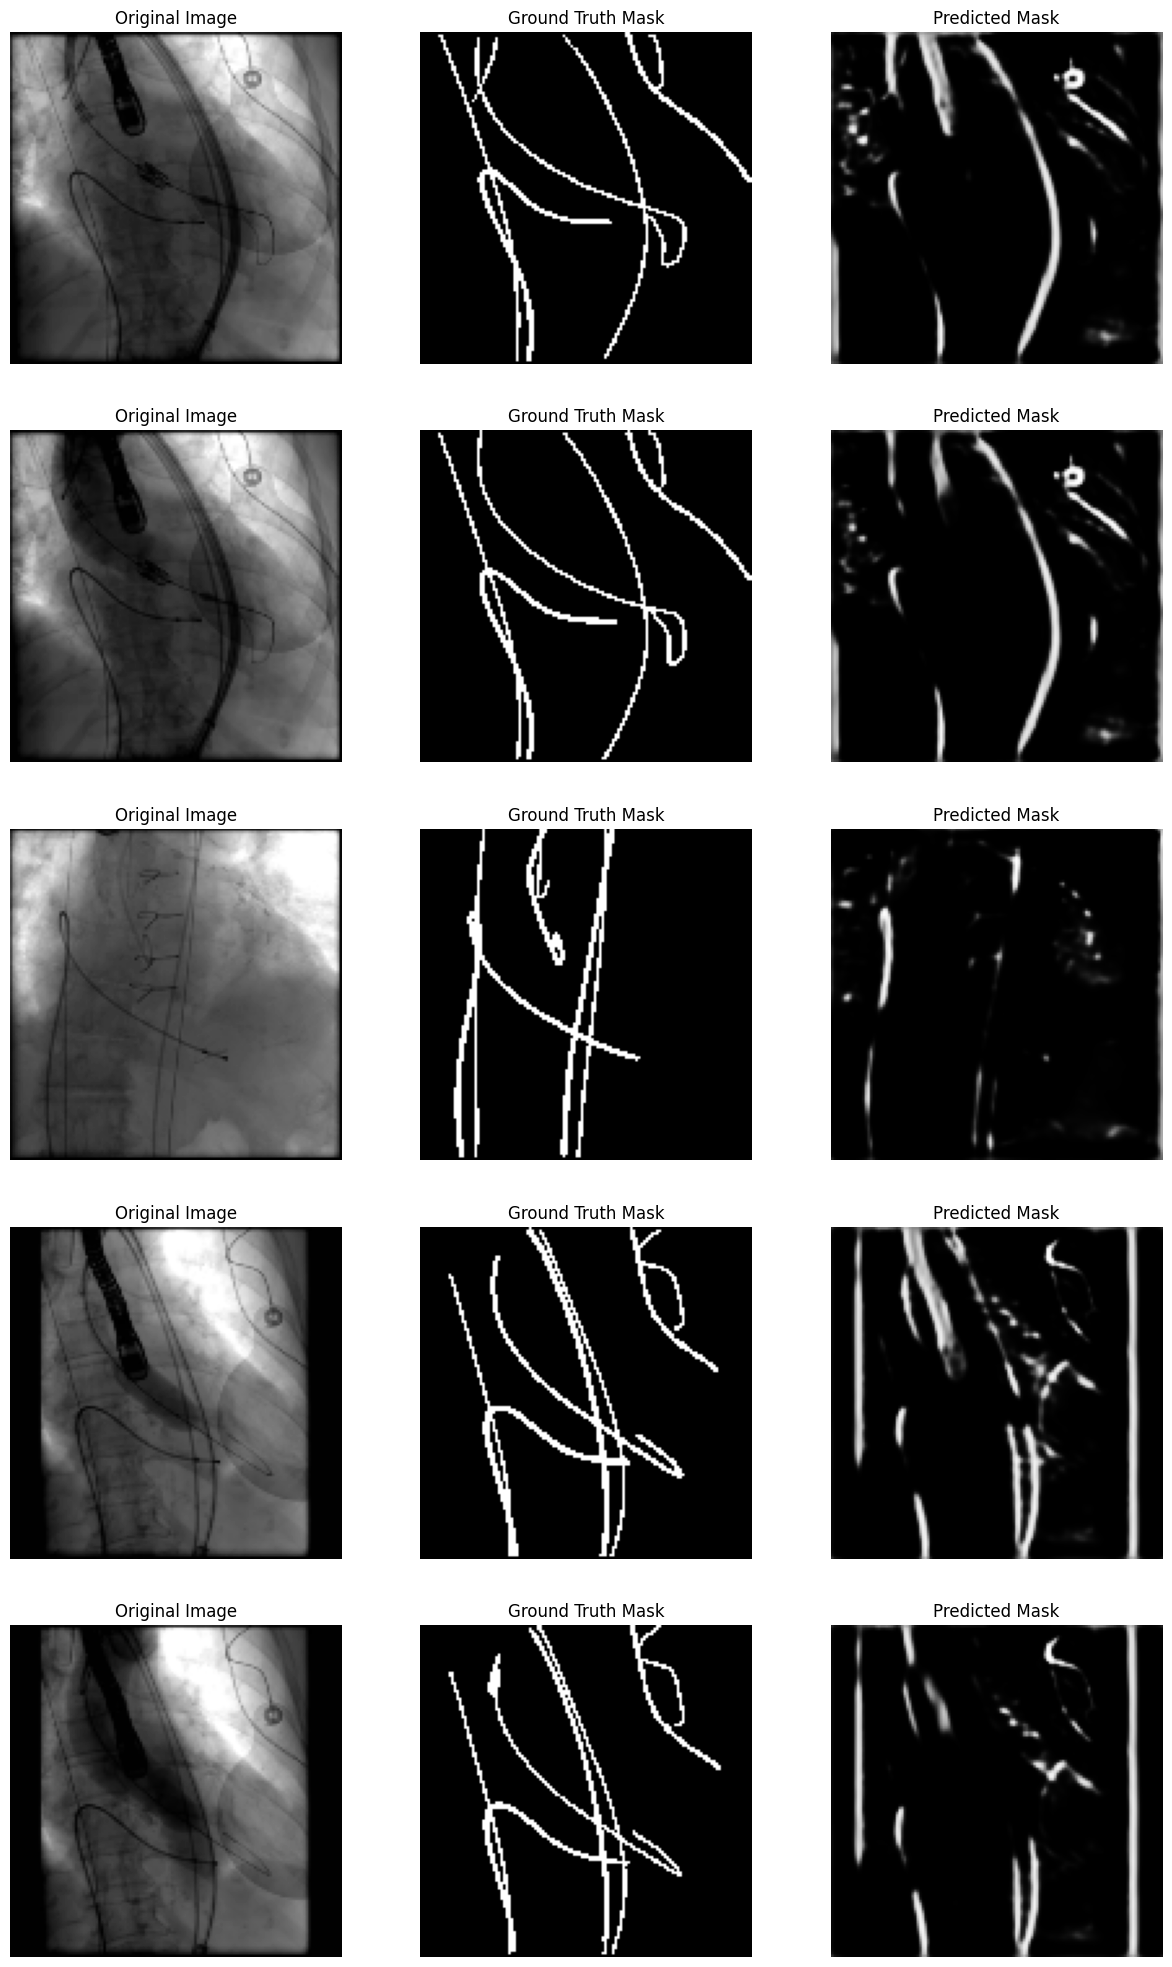

In [ ]:
predictions = model.predict(X_val)

def plot_predictions(model, X_val, y_val, num_samples=5):
    # Predict masks for the validation images
    predictions = model.predict(X_val[:num_samples])

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(np.squeeze(X_val[i]), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(np.squeeze(y_val[i]), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(np.squeeze(predictions[i]), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# Call the function to plot
plot_predictions(model, X_test, y_test)

In [ ]:
import pickle
# Save the training history
with open(history_save_path, 'wb') as f:
    pickle.dump(history.history, f)

# Save predictions on validation data
predictions = model.predict(X_val)
np.save(predictions_save_path, predictions)

# Print confirmation
print("Model, training history, and predictions saved successfully.")

13/13 [==============================] - 1s 91ms/step
Model, training history, and predictions saved successfully.


# Load Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import pickle
import numpy as np
import os

# Define the directory in Google Drive
drive_directory = '/content/drive/MyDrive/UNET_MODEL'

# Define file paths
model_save_path = os.path.join(drive_directory, 'unet_final_model.keras')
model_save_path_h5 = os.path.join(drive_directory, 'unet_final_model.h5')
history_save_path = os.path.join(drive_directory, 'training_history.pkl')
predictions_save_path = os.path.join(drive_directory, 'model_predictions.npy')

# Define custom functions
@tf.keras.utils.register_keras_serializable()
def weighted_binary_crossentropy(weights):
    @tf.keras.utils.register_keras_serializable()
    def loss(y_true, y_pred):
        y_true = tf.keras.backend.flatten(y_true)
        y_pred = tf.keras.backend.flatten(y_pred)
        loss = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        loss = loss * (weights[1] * y_true + weights[0] * (1 - y_true))
        return tf.keras.backend.mean(loss)
    return loss

#weights = [0.015, 0.98]
weights = [0.1, 0.9]
@tf.keras.utils.register_keras_serializable()
def iou_metric(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou
@tf.keras.utils.register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) + smooth)

# Load the model using the absolute path
if os.path.exists(model_save_path):
    model = load_model(model_save_path, custom_objects={
        'weighted_binary_crossentropy': weighted_binary_crossentropy(weights),
        'iou_metric': iou_metric,
        'dice_coefficient': dice_coefficient
    })
    print("Model loaded successfully from .keras file.")
else:
    print("Model file (.keras) does not exist.")

    # Load the training history
with open(history_save_path, 'rb') as f:
    history = pickle.load(f)

# Load the predictions
predictions = np.load(predictions_save_path)

# Display the loaded model summary
model.summary()

# Display the loaded training history
print("Training history keys:", history.keys())
for key, value in history.items():
    print(f"{key}: {value}")

# Display a few predictions
print("Predictions shape:", predictions.shape)
print("First prediction example:", predictions[0])

Model loaded successfully from .keras file.
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_285 (Conv2D)         (None, 128, 128, 64)         640       ['input_20[0][0]']            
                                                                                                  
 dropout_133 (Dropout)       (None, 128, 128, 64)         0         ['conv2d_285[0][0]']          
                                                                                                  
 conv2d_286 (Conv2D)         (None, 128, 128, 64)         36928     ['dropout_133[0][0]']         
                                               